# Actor-Critic Method in Reinforcement Learning

Many successful algorithms in today's reinforcement learning (such as, PPO, SAC, etc) include the idea of dividing into value and advantage.<br>
Now we improve the previous vanilla [on-policy learning](./02-policy-gradient.ipynb) architecture with this idea and see Actor-Critic architecture intuitively.<br>
In this example, I'll explain about Advantage Actor-Critic (shortly, A2C) algorithm.

> Note : The idea of dividing into value and advantage can be applied on many of algorithms including both on-policy and off-policy. See [DDPG](./05-ddpg.ipynb), which algorithm also divides into value and advantage in off-policy algorithm.

Actor-Critic is the mixed approach on both value-based Q-Learning method and policy-based method.<br>
As we saw in [Q-Learning](./00-q-learning.ipynb), it holds $ Q(s_t,a_t) = r_t + \gamma \max_a{Q_t(s_{t+1},a)} $.<br>
As you know, $ \max_a{Q_t(s_{t+1},a)} $ won't depend on action $ a $. Then we can denote $ Q(s_t,a_t) = r_t + \gamma V(s_{t+1}) $ where $ V(s) $ only depends on state $ s $. This $ V(s) $ is called a value-function.

Now we separate $ Q(s_t,a_t) $ into the following two parts :

- one is potential value $ V(s_t) $ not depending on $ a_t $
- the other part is $ A(a_t, s_t) $ (which is called **advantage**) depending on $ a_t $ in state $ s_t $.

Then $ A(a_t, s_t) $ can be written as :

$$ A(a_t, s_t) = r_t + \gamma V(s_{t+1}) - V(s_t) $$

In this method, we generate a value-function (which can also be implemented by neural networks) $ V(s) $ and apply policy gradient for an advantage-function $ A(a, s) $. We should then generate 2 functions - value function and policy function - and optimize parameters in these 2 functions.<br>
Intuitively, the value function is optimized for the value estimation in each state, and the policy function is optimized to take an appropriate action in that state.

Remind that we have applied gradient descent (ascent) on $ E\left[\sum{\gamma r}\right] $ in [vanilla on-policy learning](./02-policy-gradient.ipynb) (previous example). By applying policy gradient on the reduced $ A(a, s) $ instead of $ E\left[\sum{\gamma r}\right] $, we can expect the stable convergence in complex problems, compared with vanilla policy gradient.

For instance, imagine that the reward becomes so large.<br>
In this situation, value will become large, and the value loss will then be larger rather than policy loss.<br>
However, if the network (function) of policy and value are separated, both parameters can be appropriately optimized in the training respectively. (When these are not separated, it could happen that the policy loss will be ignored because it's relatively small, and not optimized enough eventually.)<br>
Even when sharing parameters in the network (function) between value and policy, you can adjust the ratio for policy loss and value loss in Actor-Critic method, and both can then be appropriately optimized.

You can run Actor-Critic-based training on both batch processing and non-batch processing.<br>
For instance, when you run optimization on each episode (as a batch), you can estimate advantage $ A_t $ with $ \sum{\gamma r} - V(s_t) $.<br>
When it's in the middle of episode, you can estimate with $ r_{t} + \gamma r_{t+1} + \cdots + \gamma^{T-1-t} r_{T-1} + \gamma^{T-t} V(s_T) - V(s_t) $.

> Note : This latter approach is known as **temporal difference (TD)** learning, and I don't cover this topic in this repository. (See [GAE (generalized advantage estimation)](https://arxiv.org/pdf/1506.02438) to get generalized advantages between bias and variance in TD learning.)

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [3]:
# !pip install torch numpy gymnasium matplotlib

In [4]:
# import gymnasium as gym
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import random

random.seed(20)
np.random.seed(20)
torch.manual_seed(20)

env_name = "CartPole-v1"

if env_name == "CartPole-v1":
    max_steps = 500
    convergence_criteria = 495.0
elif env_name == "CartPole-v0":
    max_steps = 200
    convergence_criteria = 195.0

The idea of Actor-Critic is similar to [policy gradient example](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/02-policy-gradient.ipynb).<br>
However, in Actor-Critic, we use a value function (the following ```ValueNet```) which estimates value (Q-value).

In this example, we separate weight's parameters between policy network (actor) and value network.<br>
However, you can also use shared network between policy and value. In that case, you should specify the ratio between policy loss and values loss.

> In order to speed up learning, I have reduced the number of hidden neurons, compared with previous policy gradient example.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

hidden_size = 64
actor_func = ActorNet(hidden_size).to(device)
value_func = ValueNet(hidden_size).to(device)

Now we optimize both policy gradient loss (following ```pi_loss```) and value loss (following ```vf_loss```) as follows.

In this example,

- I have separately optimized actor and critic with policy loss $ p $ (```pi_loss```) and value loss $ v $ (```vf_loss```) respectively. When they are shared, you should specify loss ratio $ 0 \lt \rho \lt 1$ by computing $ (1-\rho) p + \rho v $.
- I have simply used cumulative rewards $\sum{\gamma r}$ as an estimated value in batch. (When it's in the middle of episode, you can also use $ r_{t} + \gamma V(s_{t+1}) $ instead. See above note for TD approach.)

> Note : The log probability is equivalent to the negative value of cross-entropy error in categorical distribution. Same like [policy gradient example](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/02-policy-gradient.ipynb), I have used ```-torch.nn.functional.cross_entropy()``` to get log probability in the following code.

In [8]:
gamma = 0.99
epoch = 1000
# pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make(env_name)
reward_records = []
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.009)
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.009)

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position



for i in range(epoch):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    env.seed(i)
    s = env.reset()
    env.seed(i)
    
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        
        # Compute custom rewards
        # Extract state variables
        x = abs(s[0])  # Cart position (absolute value)
        theta = abs(s[2])  # Pole angle (absolute value)
        
        weight1=0.165
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward
        
        
        done = term or trunc
        actions.append(a)
        # rewards.append(r)
        rewards.append(reward)
        

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    
    #
    # Train (optimize parameters)
    #

    # Optimize value loss (Critic)
    opt1.zero_grad()
    states = torch.tensor(states, dtype=torch.float).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    values = value_func(states)
    values = values.squeeze(dim=1)
    vf_loss = F.mse_loss(
        values,
        cum_rewards,
        reduction="none")
    vf_loss.sum().backward()
    opt1.step()

    # Optimize policy loss (Actor)
    with torch.no_grad():
        values = value_func(states)
    opt2.zero_grad()
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    advantages = cum_rewards - values
    logits = actor_func(states)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    pi_loss = -log_probs * advantages
    pi_loss.sum().backward()
    opt2.step()

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, reward_len), end="\r")
    reward_records.append(reward_len)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) >= convergence_criteria:
        break

print("\nDone")
env.close()

Run episode208 with rewards 500
Done


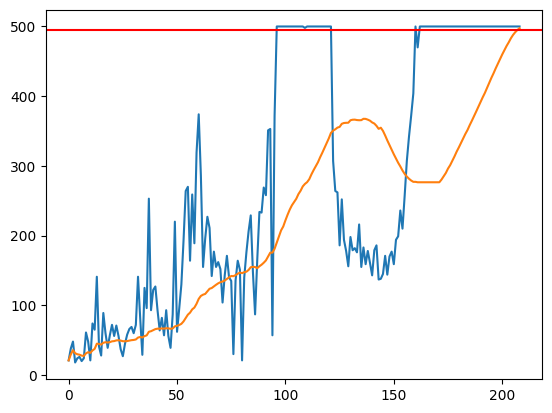

In [9]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)
plt.axhline(y=convergence_criteria, color='r', linestyle='-')
plt.show()

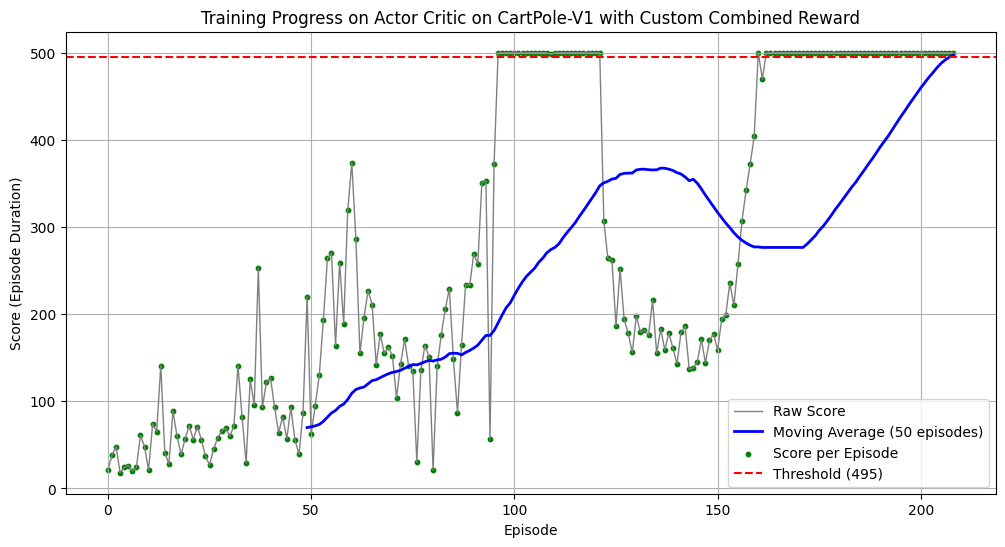

In [14]:
# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):
    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=495, color='red', linestyle='--', label='Threshold (495)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    # plt.title('Training Progress of %s on CartPole with Custom Combined Reward'%(name))
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_train('Actor Critic on CartPole-V1', reward_records, 50)

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
count    100.0
mean     500.0
std        0.0
min      500.0
25%      500.0
50%      500.0
75%      500.0
max      500.0
Name: score, dtype: float64
success
True    100
Name: count, dtype: int64


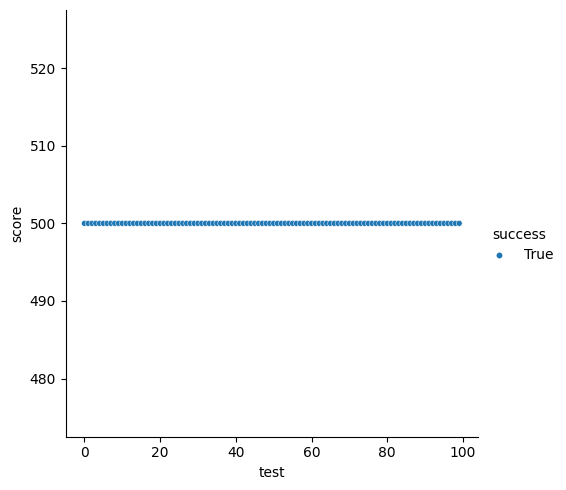

In [11]:
import pandas as pd
import seaborn as sns

def test_agent_500(i, print_reward=False):
    env = gym.make('CartPole-v1')
    env.seed(i)
    s = env.reset()
    env.seed(i)
    rewards = []
    obs=[]
    for t in range(500):
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        done = term or trunc
        rewards.append(r)
        #print(sum(rewards))  
        if done:
            rew = sum(rewards)
            if print_reward:
                print("Reward:", rew)
            return rew
    env.close()


def plot_test_results_500(total=100):
    test_scores = []
    for i in range(total):
        test_scores.append(test_agent_500(i, print_reward=False))
        
    print(test_scores)

    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>=495)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    sns.relplot(data=test_df, x="test", y="score", hue="success", size="success")
    plt.show()
    
plot_test_results_500(total=100)

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: score, dtype: float64
success
True    100
Name: count, dtype: int64


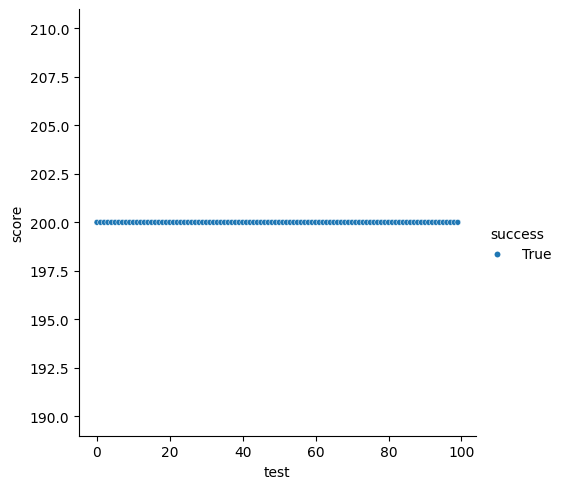

In [12]:
import pandas as pd
import seaborn as sns

def test_agent(i, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(i)
    s = env.reset()
    env.seed(i)
    rewards = []
    obs=[]
    for t in range(200):
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        done = term or trunc
        rewards.append(r)
        #print(sum(rewards))  
        if done:
            rew = sum(rewards)
            if print_reward:
                print("Reward:", rew)
            return rew
    env.close()


def plot_test_results(total=100):
    test_scores = []
    for i in range(total):
        test_scores.append(test_agent(i, print_reward=False))
        
    print(test_scores)

    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>=195)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    sns.relplot(data=test_df, x="test", y="score", hue="success", size="success")
    plt.show()
    
plot_test_results(total=100)